Install/Import libraries

In [ ]:
!apt install tesseract-ocr
!pip install pymupdf pytesseract opencv-python pillow
import fitz
import cv2
import pytesseract
import numpy as np
from PIL import Image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 56.7 MB/s eta 0:00:00


Upload File

In [ ]:
from google.colab import files

uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

doc = fitz.open(pdf_path)

Saving MTG_10009588.pdf to MTG_10009588 (1).pdf


Get Pages and convert to images

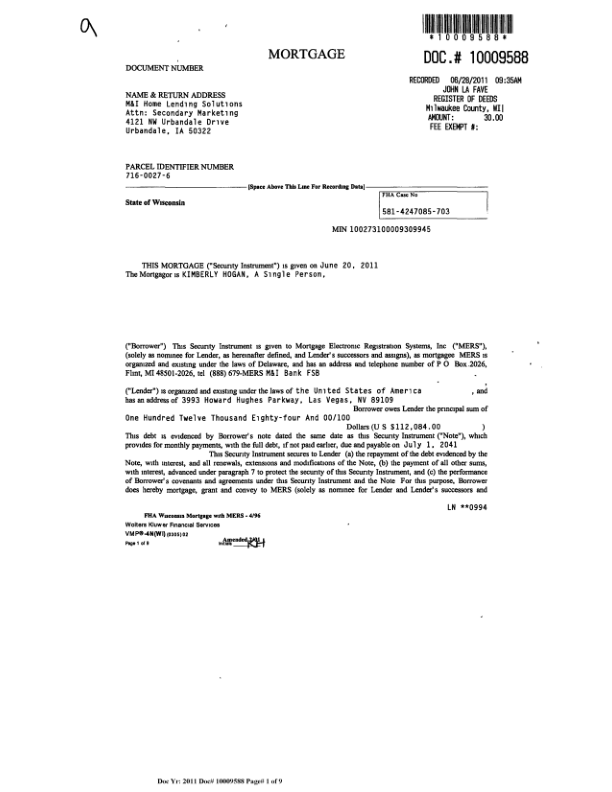

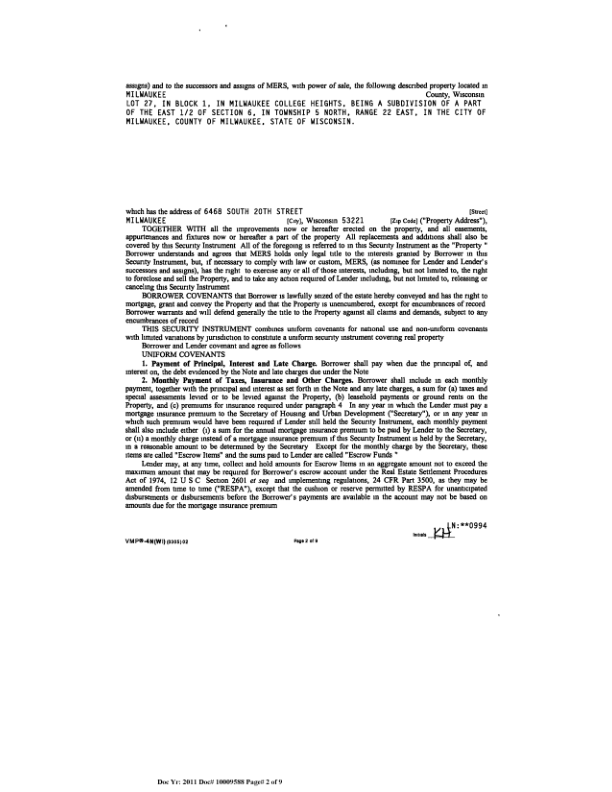

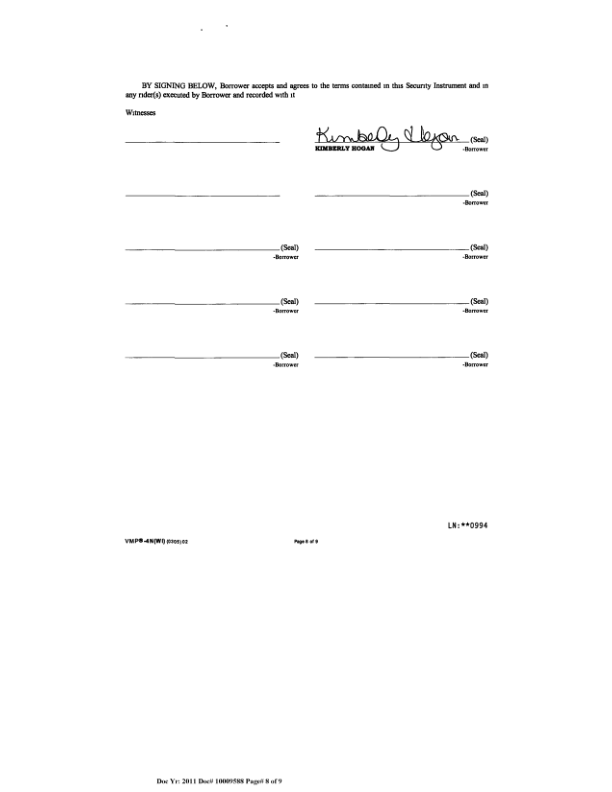

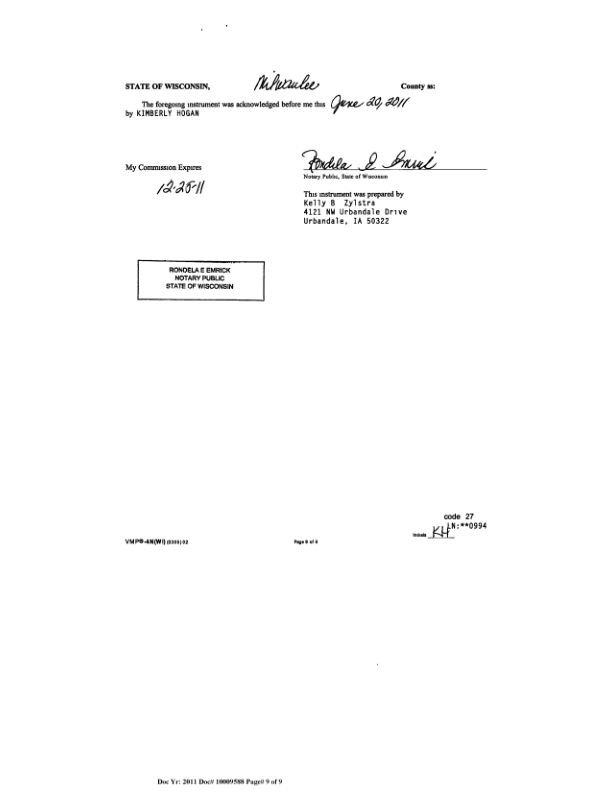

In [ ]:
images = []
for page in doc:
  pix = page.get_pixmap()
  img = np.array(Image.frombytes("RGB", [pix.width, pix.height], pix.samples))
  images.append(img)
  display(Image.fromarray(img))

Preprocess Images

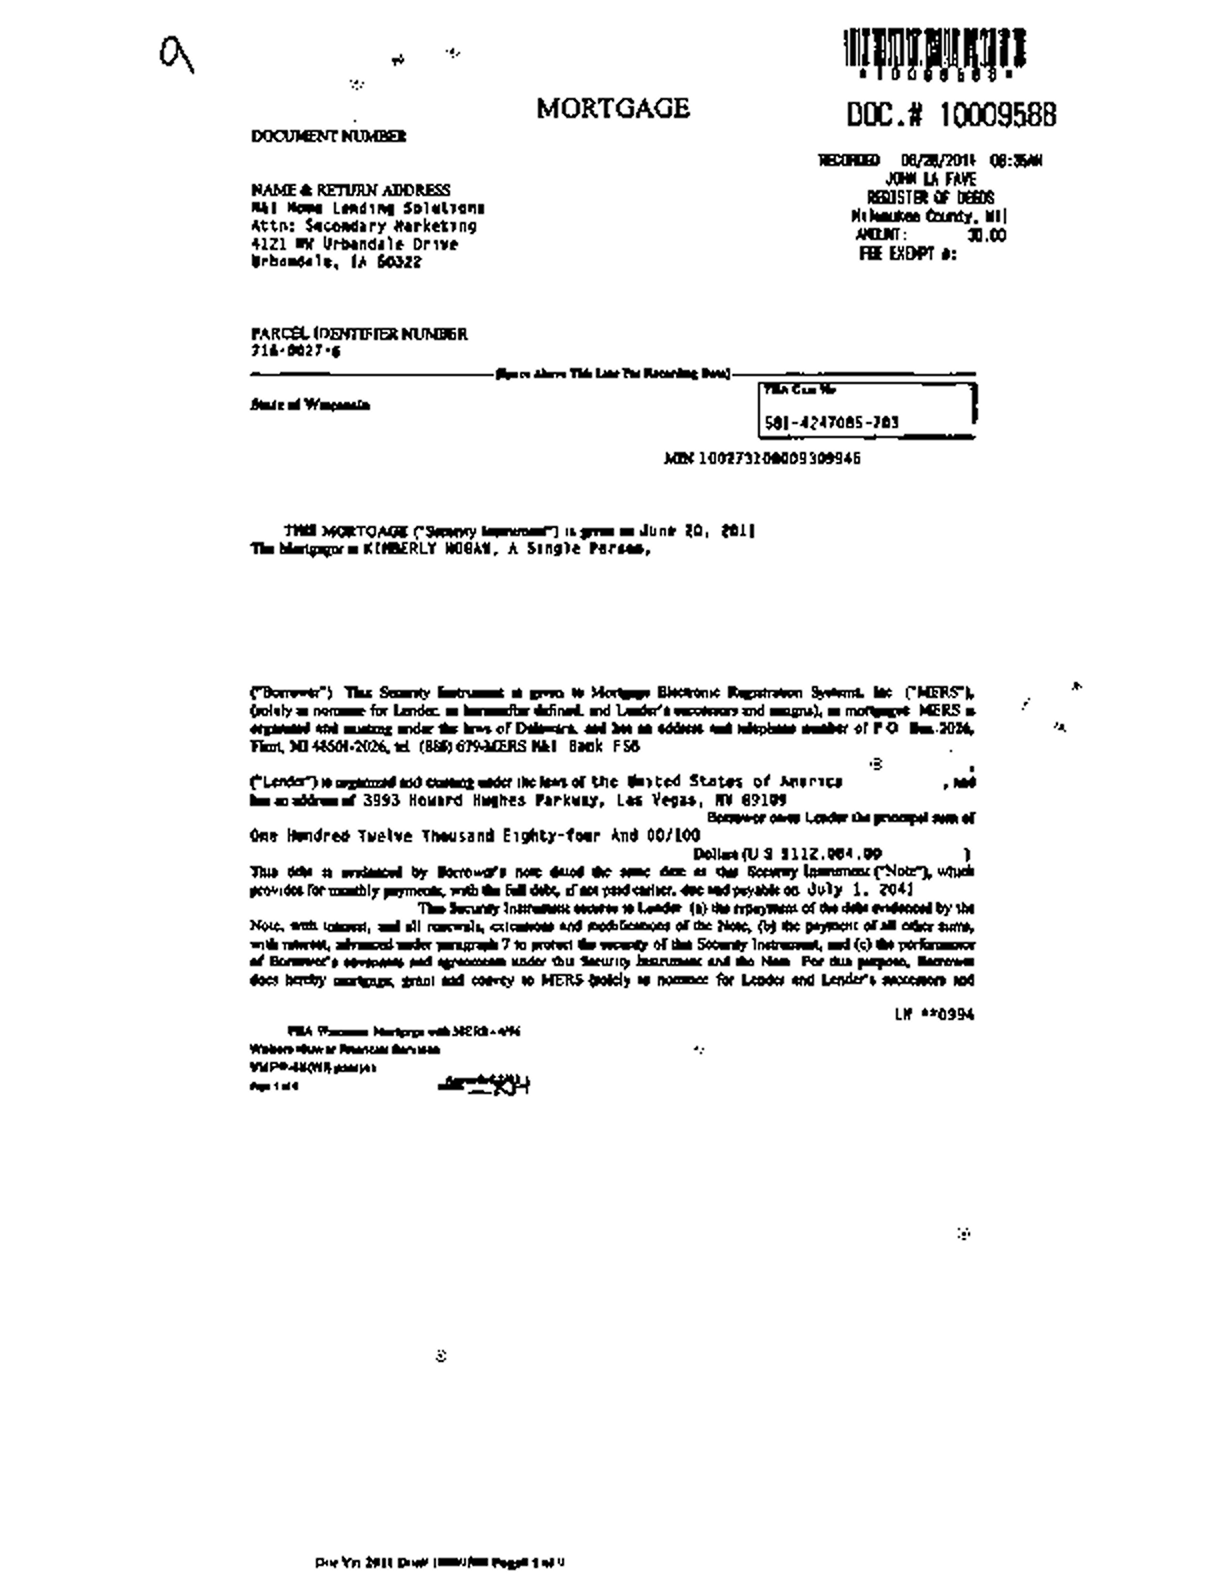

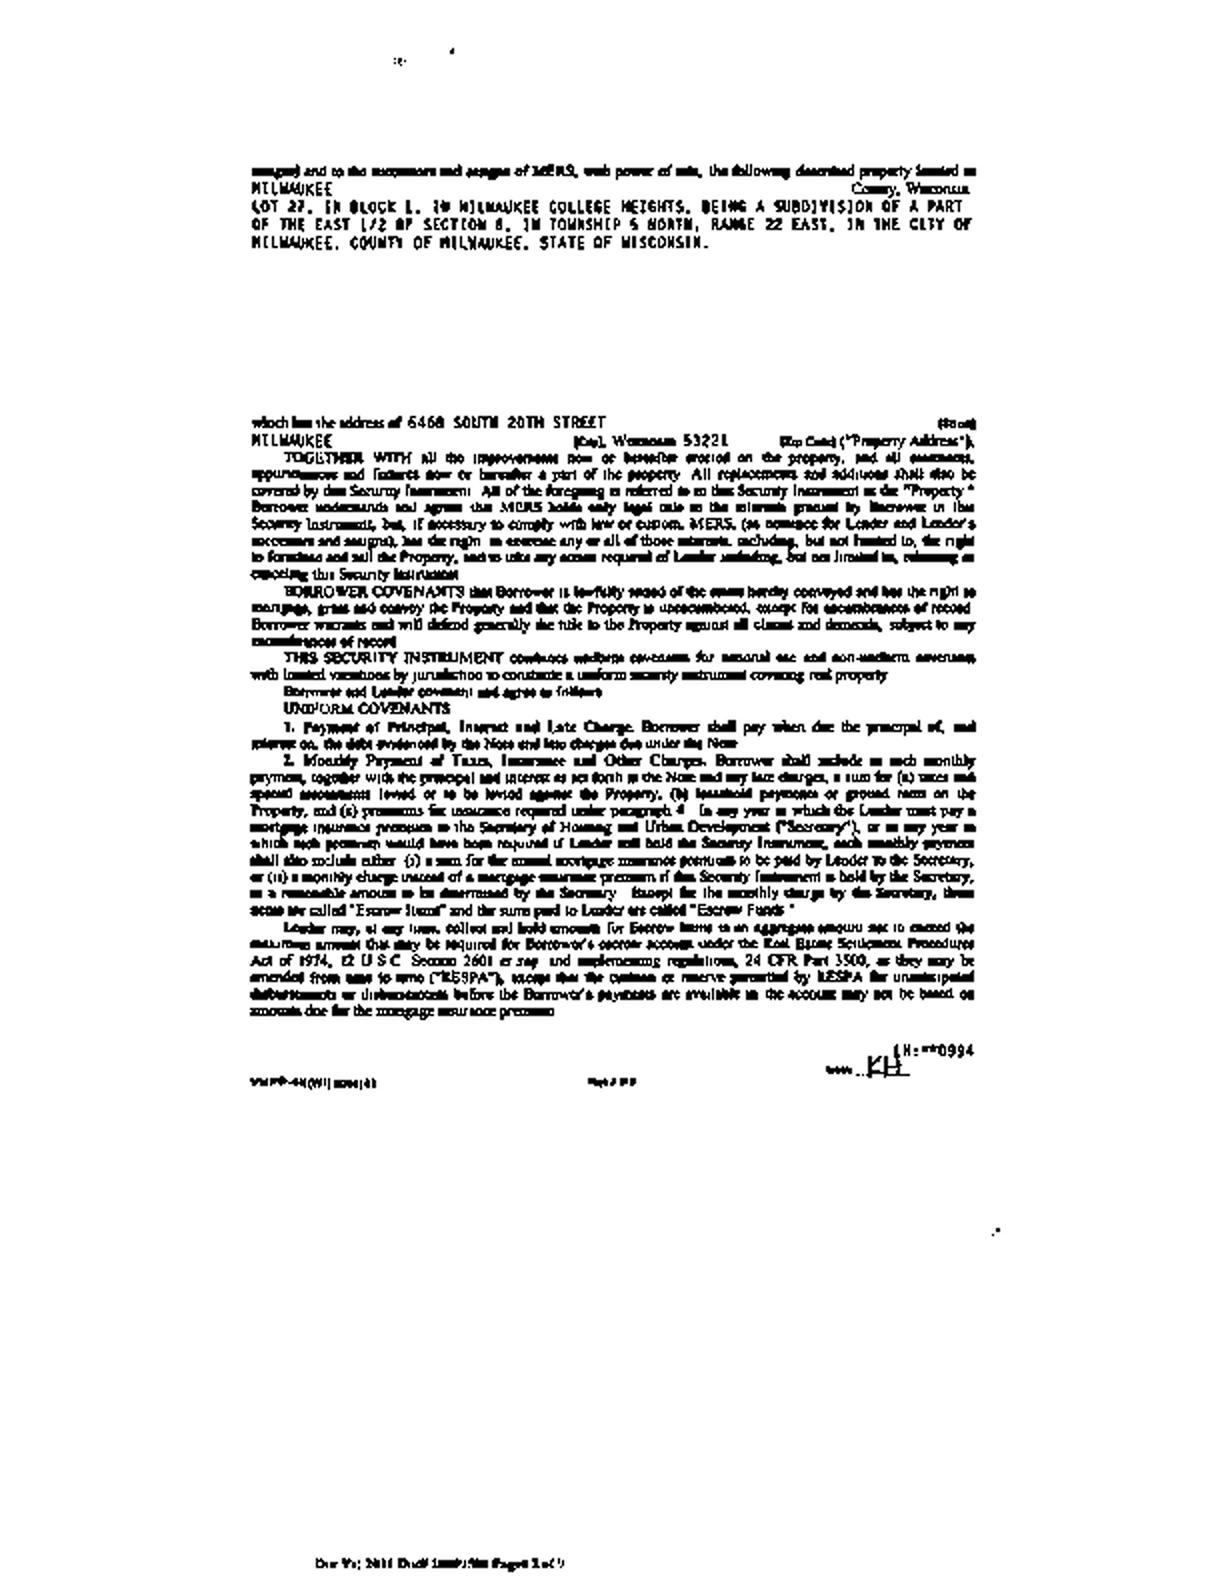

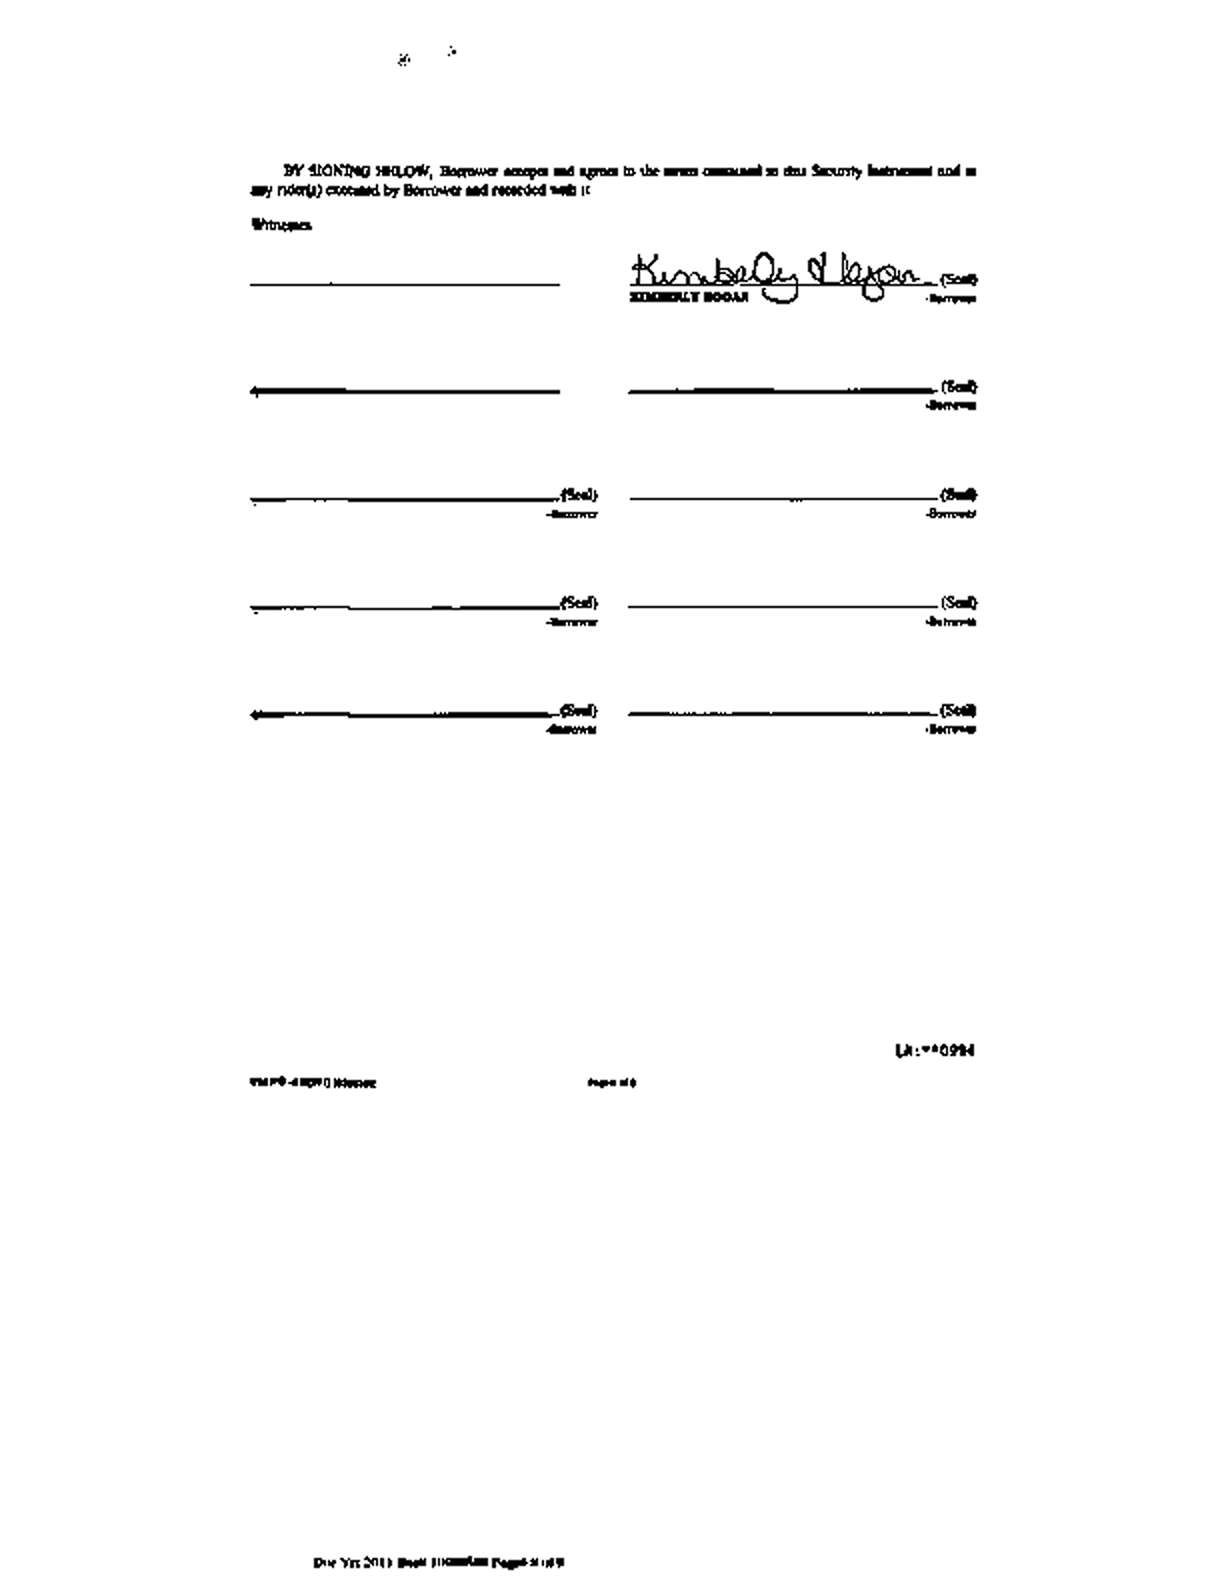

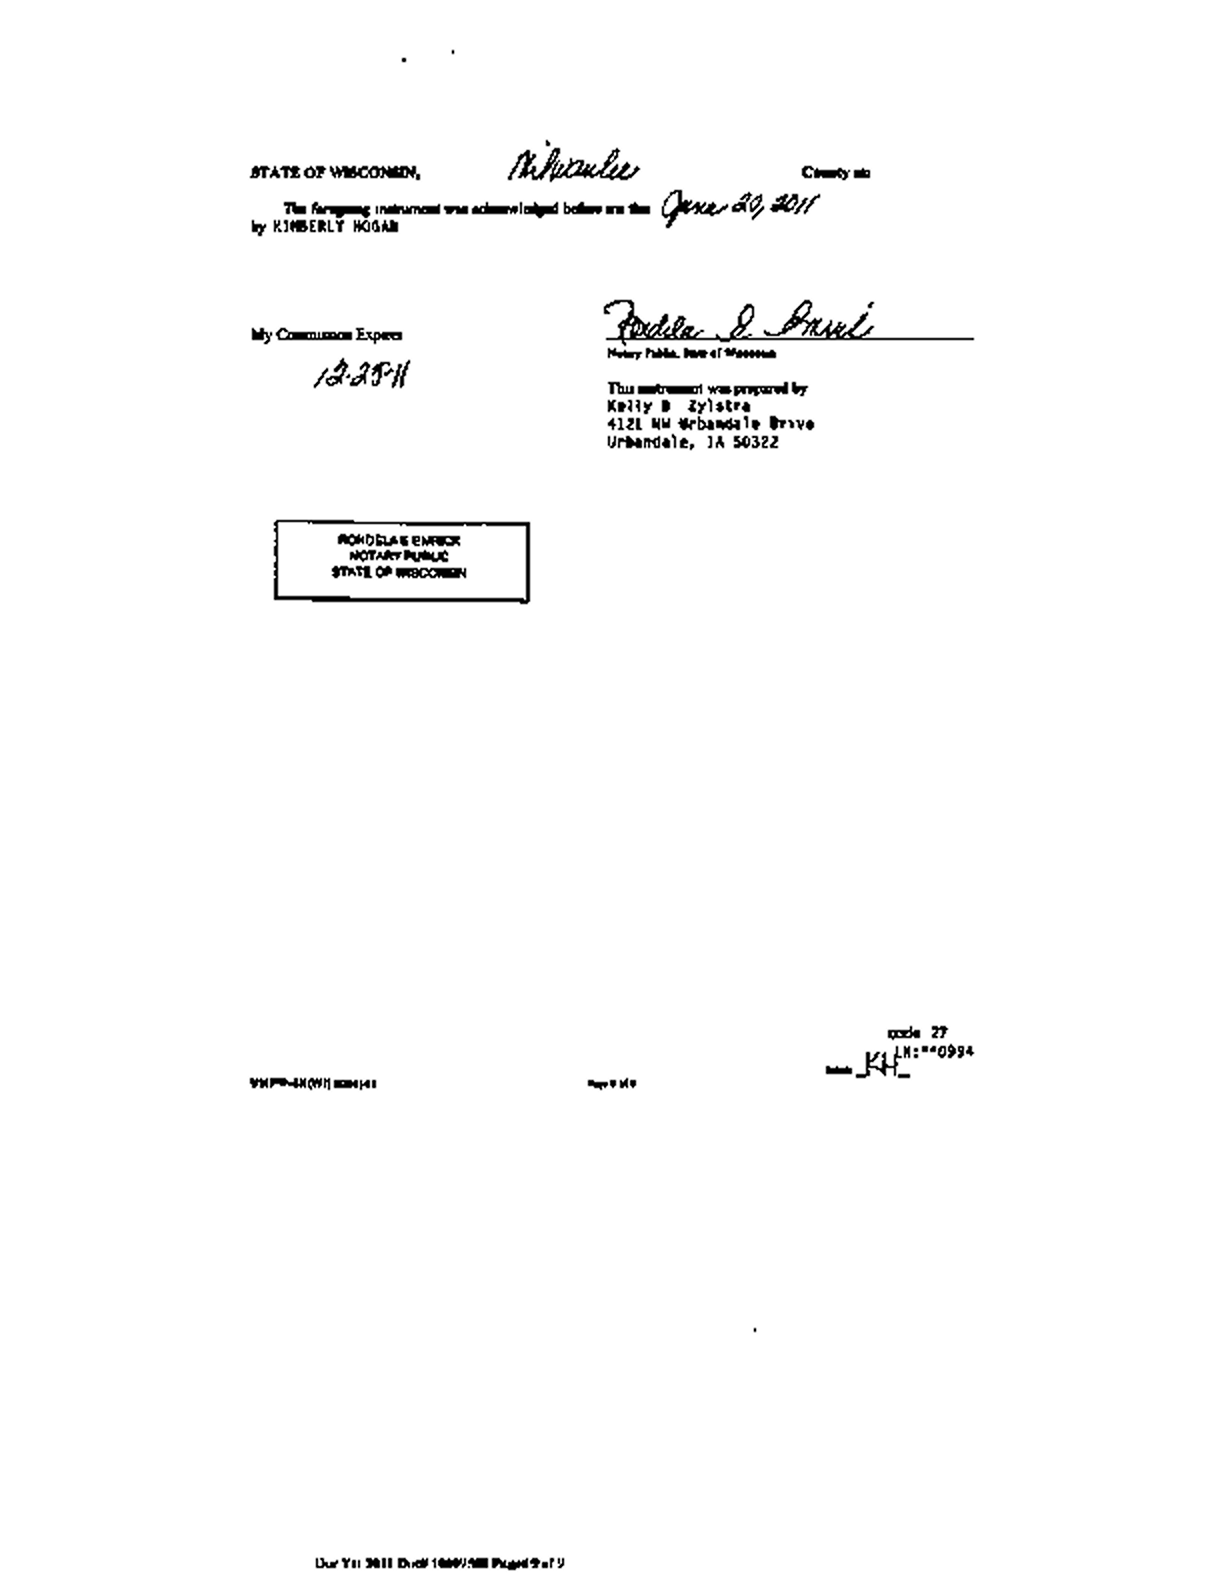

In [ ]:
gray_imgs = []
for img in images:
  # Convert image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # Apply Bilateral Filtering to reduce noise while preserving edges
  gray = cv2.bilateralFilter(gray, 9, 75, 75)


  # Apply Adaptive Thresholding for contrast enhancement
  gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

  # Resize image for better OCR accuracy (Tesseract performs better on larger text)
  scale_percent = 200  # Increase image size by 200%
  width = int(gray.shape[1] * scale_percent / 100)
  height = int(gray.shape[0] * scale_percent / 100)
  gray = cv2.resize(gray, (width, height), interpolation=cv2.INTER_CUBIC)
  gray_imgs.append(gray)
  # Show the preprocessed image
  display(Image.fromarray(gray))

Perform OCR and extract bboxes

In [ ]:
custom_config = r'--oem 3 -l eng'
ocr_texts = []
ocr_datas = []
for gray_img in gray_imgs:
  ocr_text = pytesseract.image_to_string(gray_img, config=custom_config)
  ocr_texts.append(ocr_text)
  print("EXTRACTED OCR TEXT:\n", ocr_text)

  ocr_data = pytesseract.image_to_data(gray_img, output_type=pytesseract.Output.DICT)
  ocr_datas.append(ocr_data)
  for i in range(len(ocr_data)):
    print(f"Word: {ocr_data['text'][i]}, BBox: ({ocr_data['left'][i]}, {ocr_data['top'][i]}, {ocr_data['width'][i]}, {ocr_data['height'][i]})")

EXTRACTED OCR TEXT:
  

 

 

-* TA

MORTGAGE DOC.# 10009588
DOCUMENT NUMBER
HEAD VATON com

nae S RETURN ADDRESS RERISTER OF DEEDS

ending Solatvans Wu keaukes County, ul
Attn: Sccontary Rerketvag MMT : 00
4121 WX Urbandale Drive i .
Urbemgele, 14 60322 FE EXDPT a:
PARCEL (DENTIFIER NUMBER
F1d- O02 +6

Pig ce Aderrs Tht Lane Pad Racaring Bara).
fate od Wencanain ™
S@1-4247085-263
MIN 1100279200009 309946

THEE MORTOAGE CSeemevy Megmenant”) 16 gerem ee dune 20, 2011
Ths Dderigagor m KIMBERLY ROGAN, A Singde Parces,

(Dorewer") Ths Scomoty lewtrmeet ot erevo W Mortgapy Biecrone Regstraeon Syetert, lee COMERS)
Golely ae nero for Lender. mn heermmefber defined. ond Lemder’s wecoterars and mengrs), mm motgagrt MERS w
et phtatid srk muting andar the bres of Dilemcich. td Det th 4Gceet tend lepine weber of FO may
‘Fant, MO 48SCH-226, tel (BER) EPACERS MI Bak FSS
=
C Lender") oo onxecread 030 Content wadct Inc heat of the Uarted States of Anerics 7)
hen 20 ahirem af 3593 Howard Hughes Parkway

Post-OCR Processing

In [ ]:
import re
import json
for ocr_text in ocr_texts:
  ocr_text = " ".join(ocr_text.split())
  ocr_text = re.sub(r'[^a-zA-Z0-9\s,.%-]', '', ocr_text)

  ocr_text = re.sub(r'\bL0AN\b', 'LOAN', ocr_text, flags=re.IGNORECASE)
  ocr_text = re.sub(r'\bM0RTGAGE\b', 'MORTGAGE', ocr_text, flags=re.IGNORECASE)
  ocr_text = re.sub(r'\b1NTEREST\b', 'INTEREST', ocr_text, flags=re.IGNORECASE)

  print("Final Cleaned OCR Text:\n", ocr_text)

Final Cleaned OCR Text:
 - TA MORTGAGE DOC. 10009588 DOCUMENT NUMBER HEAD VATON com nae S RETURN ADDRESS RERISTER OF DEEDS ending Solatvans Wu keaukes County, ul Attn Sccontary Rerketvag MMT  00 4121 WX Urbandale Drive i . Urbemgele, 14 60322 FE EXDPT a PARCEL DENTIFIER NUMBER F1d- O02 6 Pig ce Aderrs Tht Lane Pad Racaring Bara. fate od Wencanain  S1-4247085-263 MIN 1100279200009 309946 THEE MORTOAGE CSeemevy Megmenant 16 gerem ee dune 20, 2011 Ths Dderigagor m KIMBERLY ROGAN, A Singde Parces, Dorewer Ths Scomoty lewtrmeet ot erevo W Mortgapy Biecrone Regstraeon Syetert, lee COMERS Golely ae nero for Lender. mn heermmefber defined. ond Lemders wecoterars and mengrs, mm motgagrt MERS w et phtatid srk muting andar the bres of Dilemcich. td Det th 4Gceet tend lepine weber of FO may Fant, MO 48SCH-226, tel BER EPACERS MI Bak FSS  C Lender oo onxecread 030 Content wadct Inc heat of the Uarted States of Anerics 7 hen 20 ahirem af 3593 Howard Hughes Parkway, Les Vegas, AV 69109 Beemece aay Lo

Draw Bounding Boxes

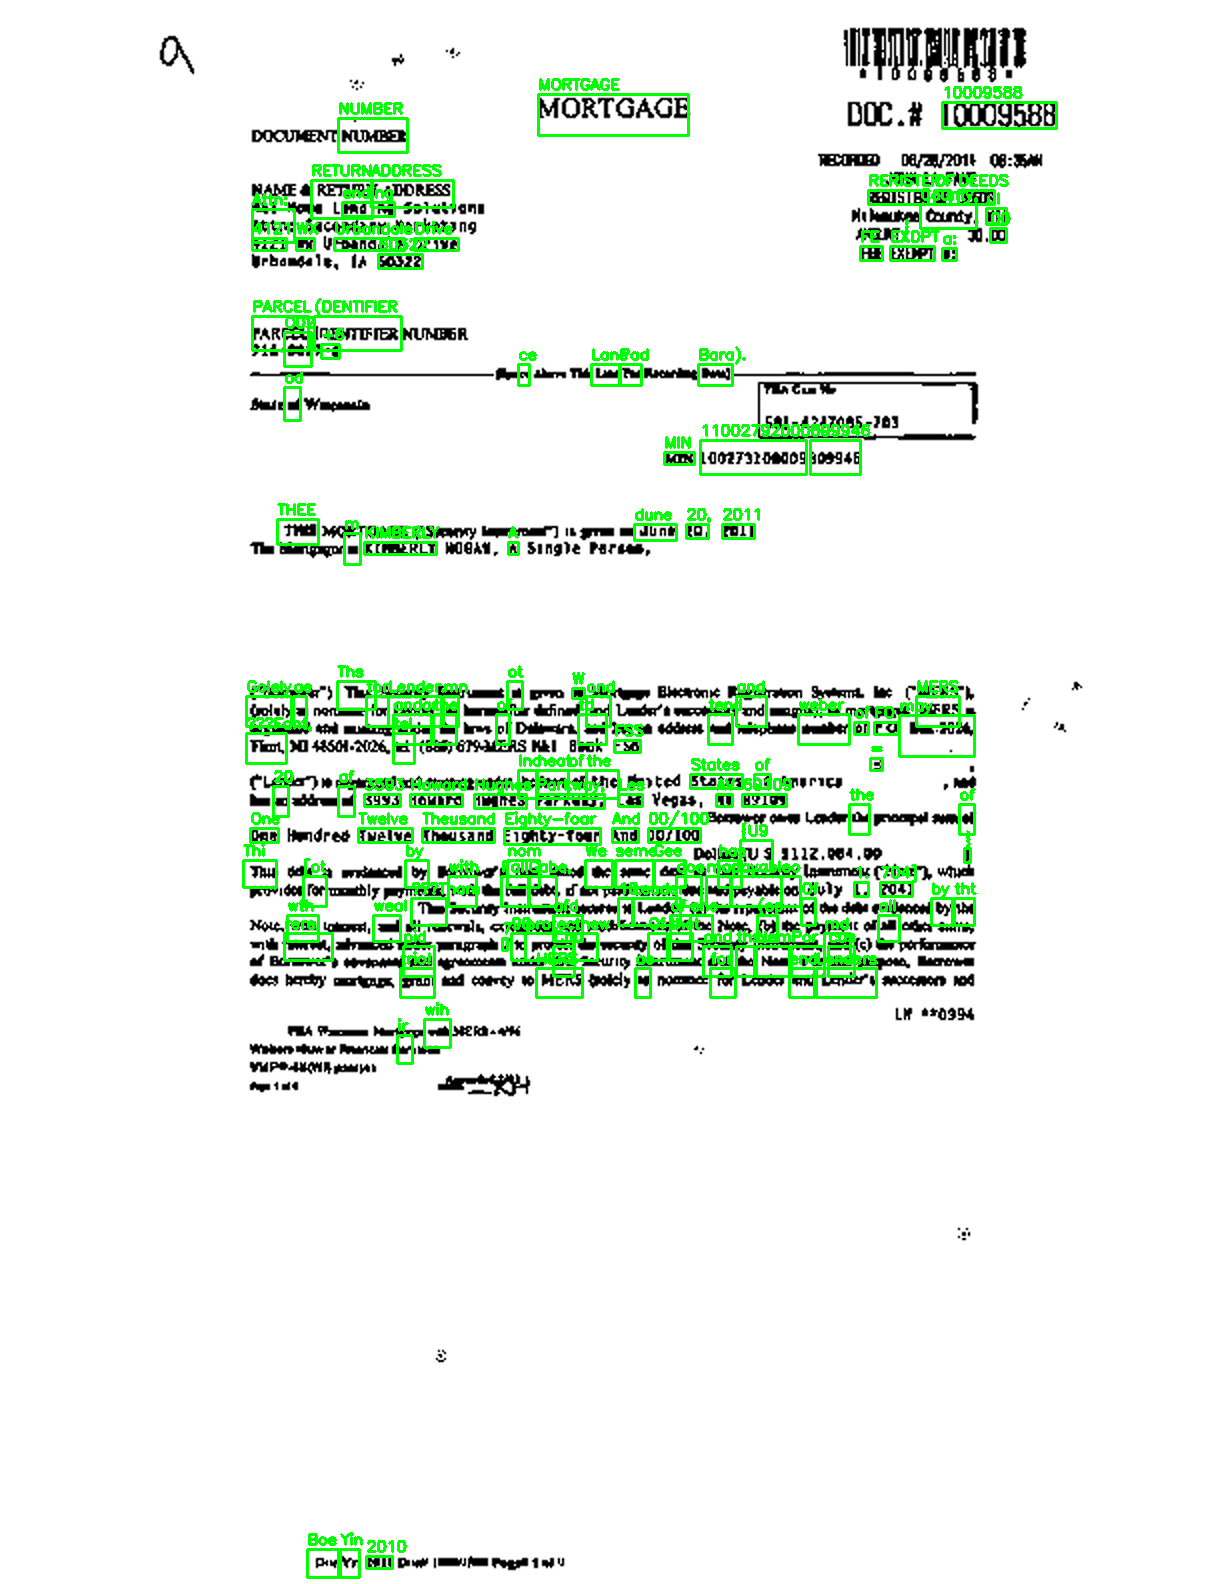

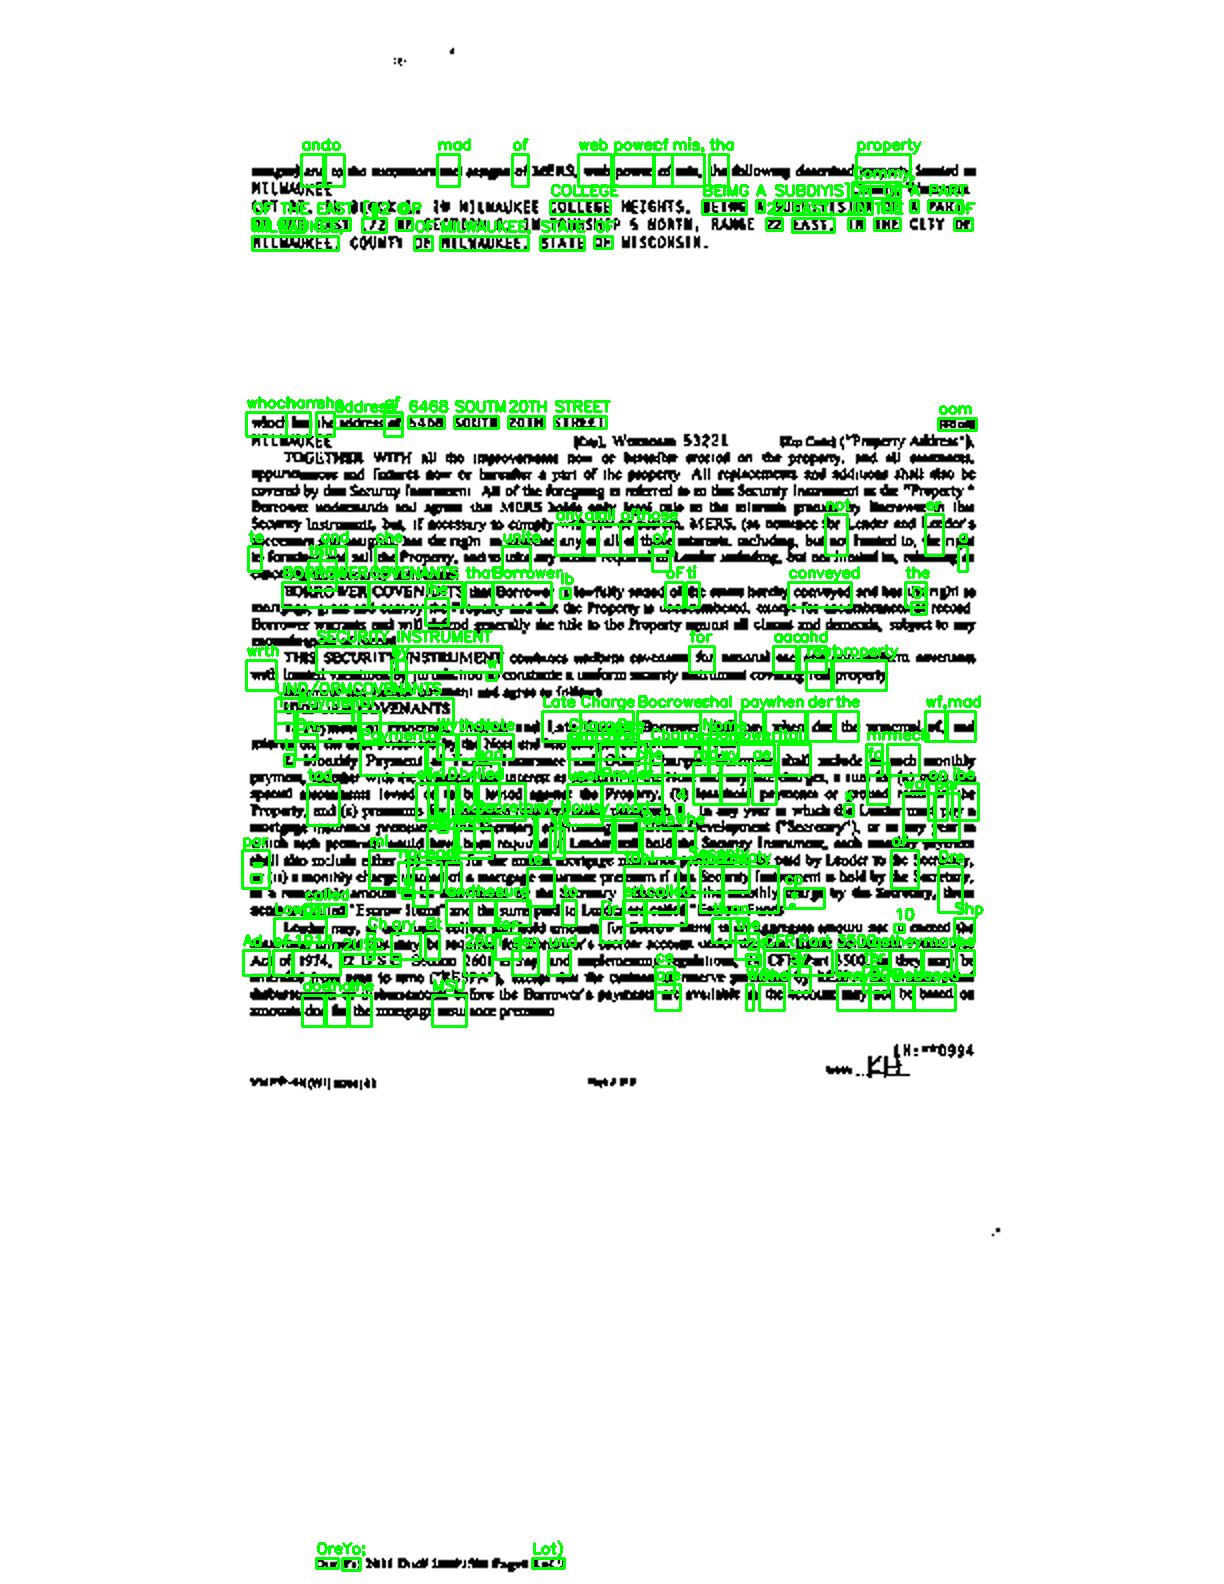

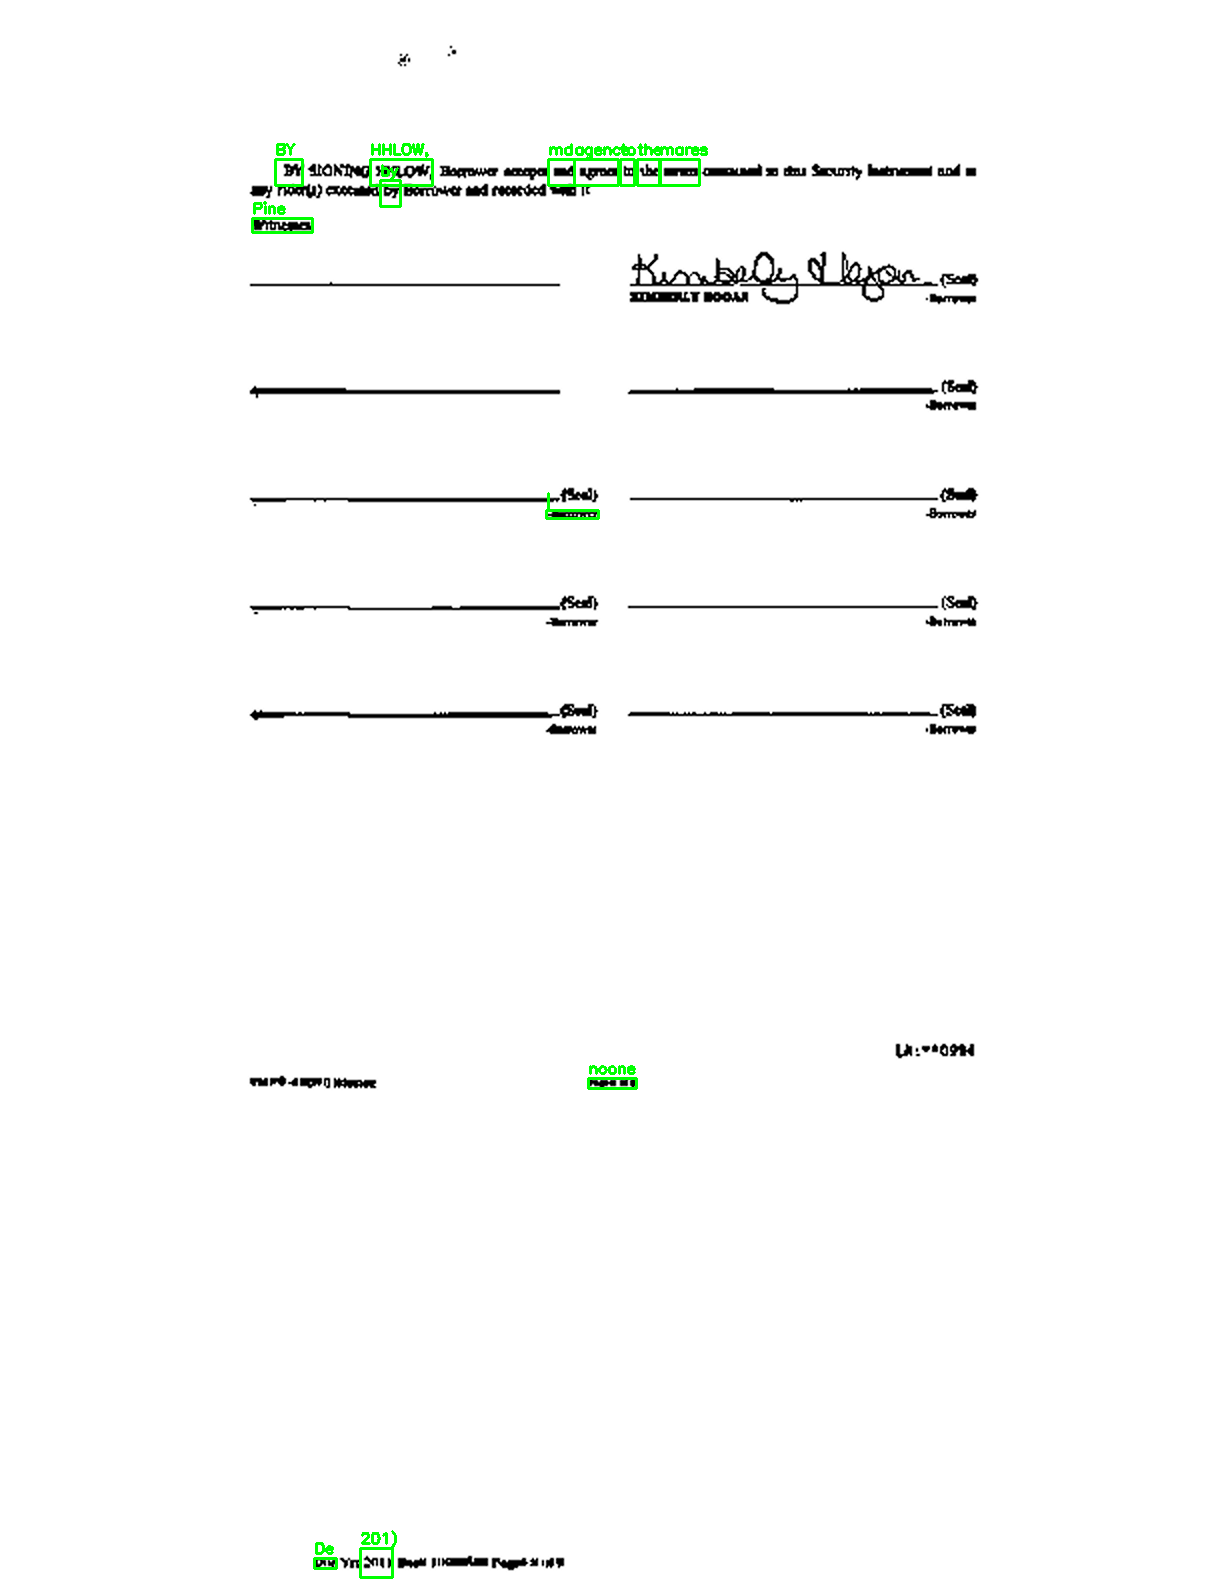

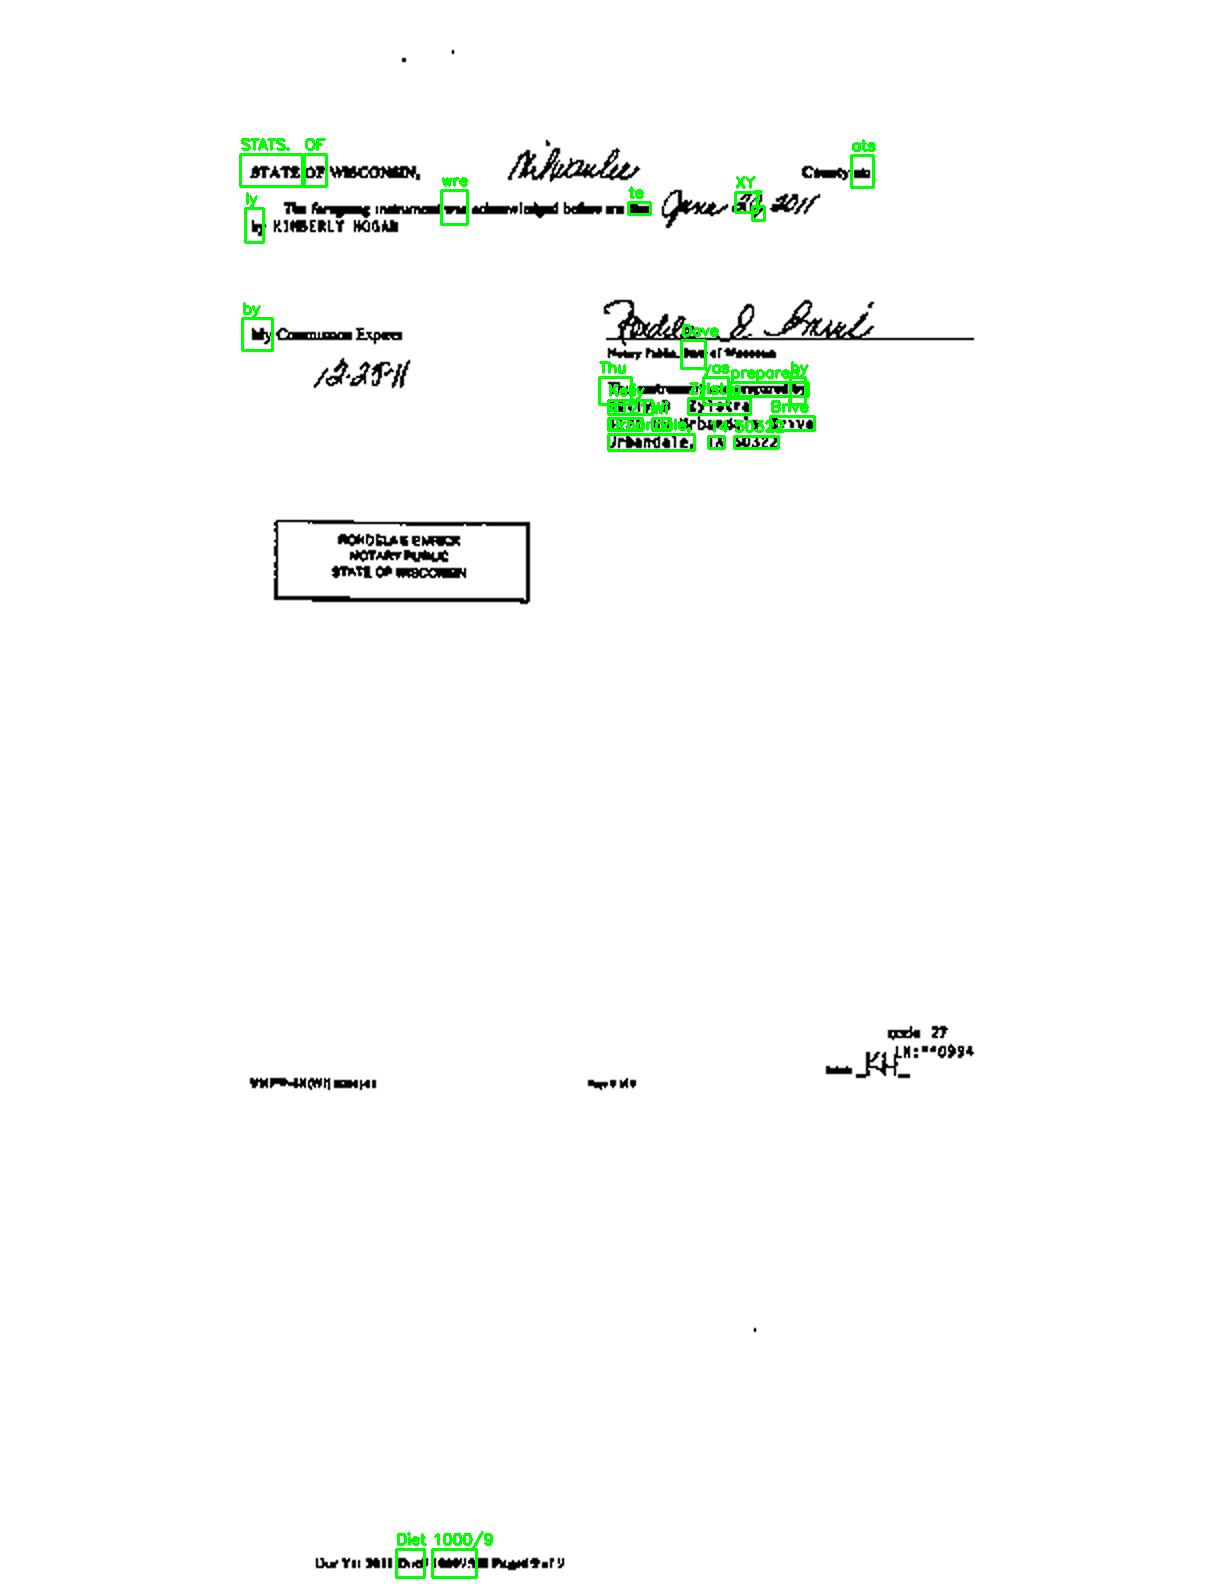

In [ ]:
import cv2
from PIL import Image

for gray_img, ocr_data in zip(gray_imgs, ocr_datas):
  img_bgr = cv2.cvtColor(gray_img, cv2.COLOR_RGB2BGR)

  confidence_threshold = 40

  for i in range(len(ocr_data['text'])):
    word = ocr_data['text'][i].strip()
    x, y, w, h = ocr_data['left'][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
    conf = int(ocr_data['conf'][i])

    if not word or conf < confidence_threshold:
      continue


    cv2.rectangle(img_bgr, (x,y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_bgr, word, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(img_rgb))

Draw Bounding Boxes for Key Terms

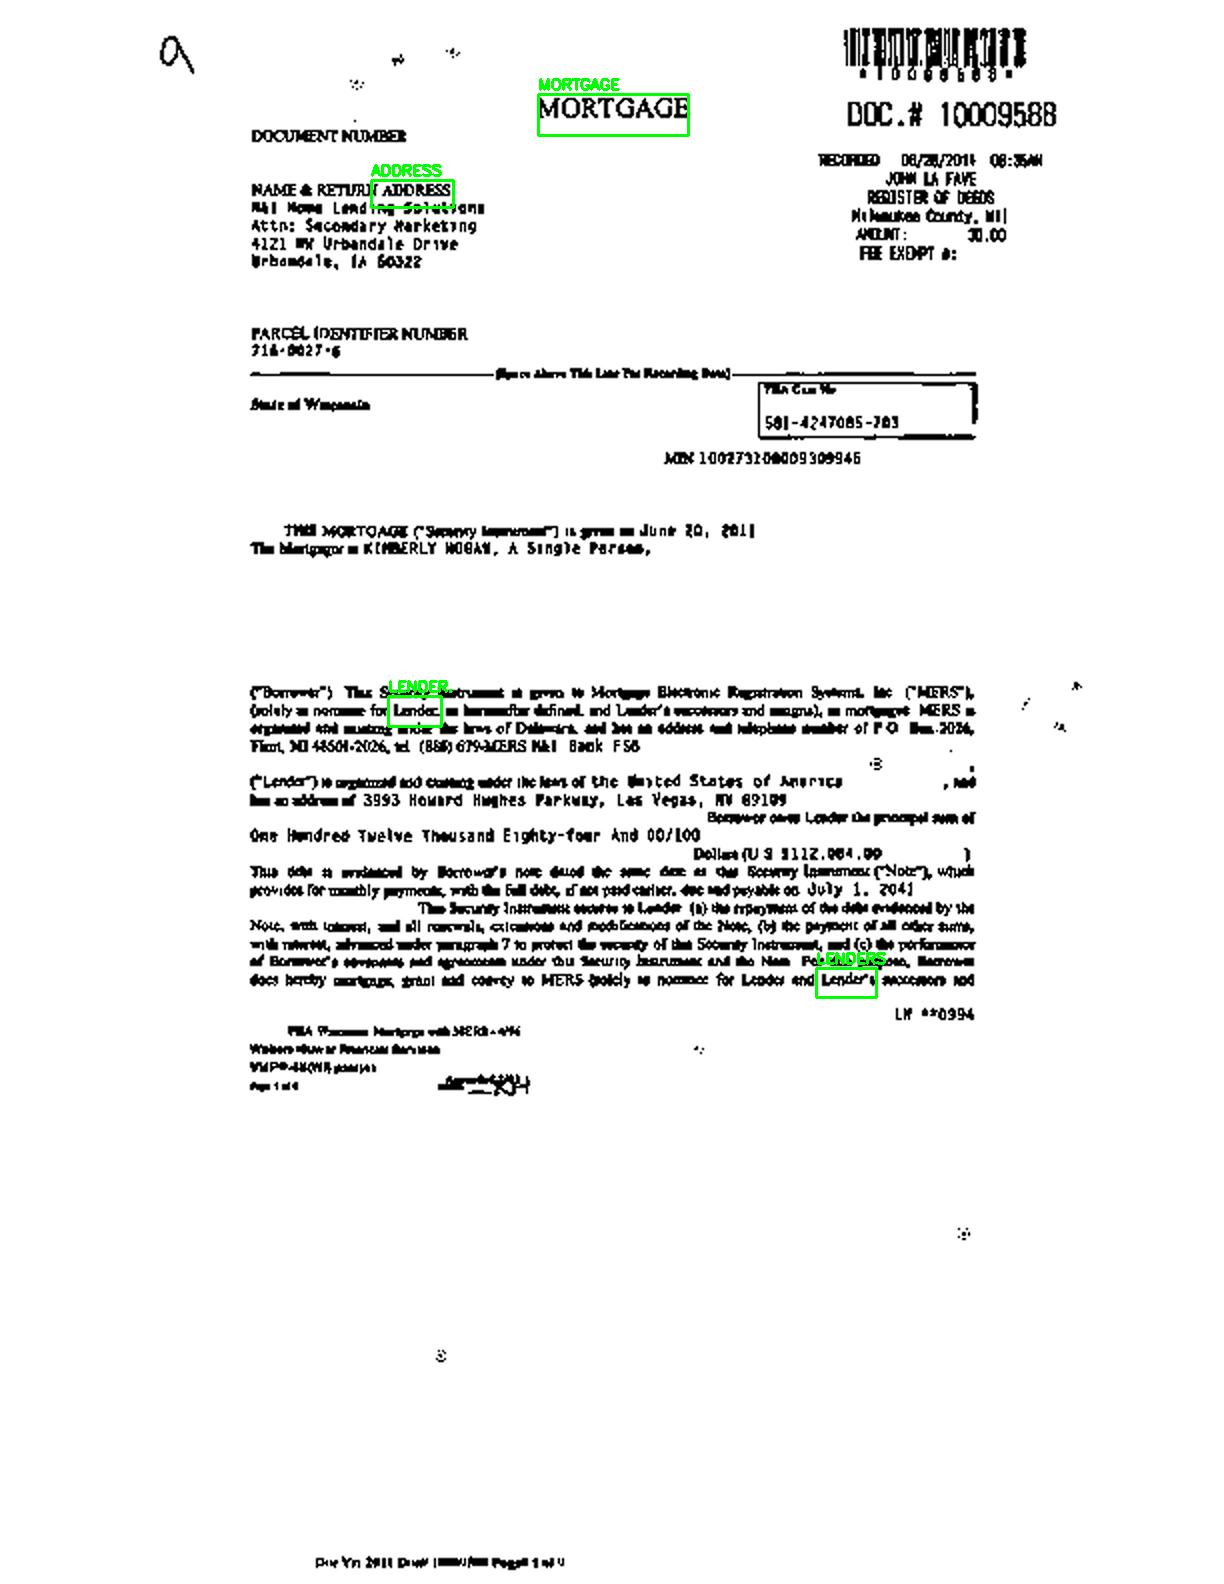

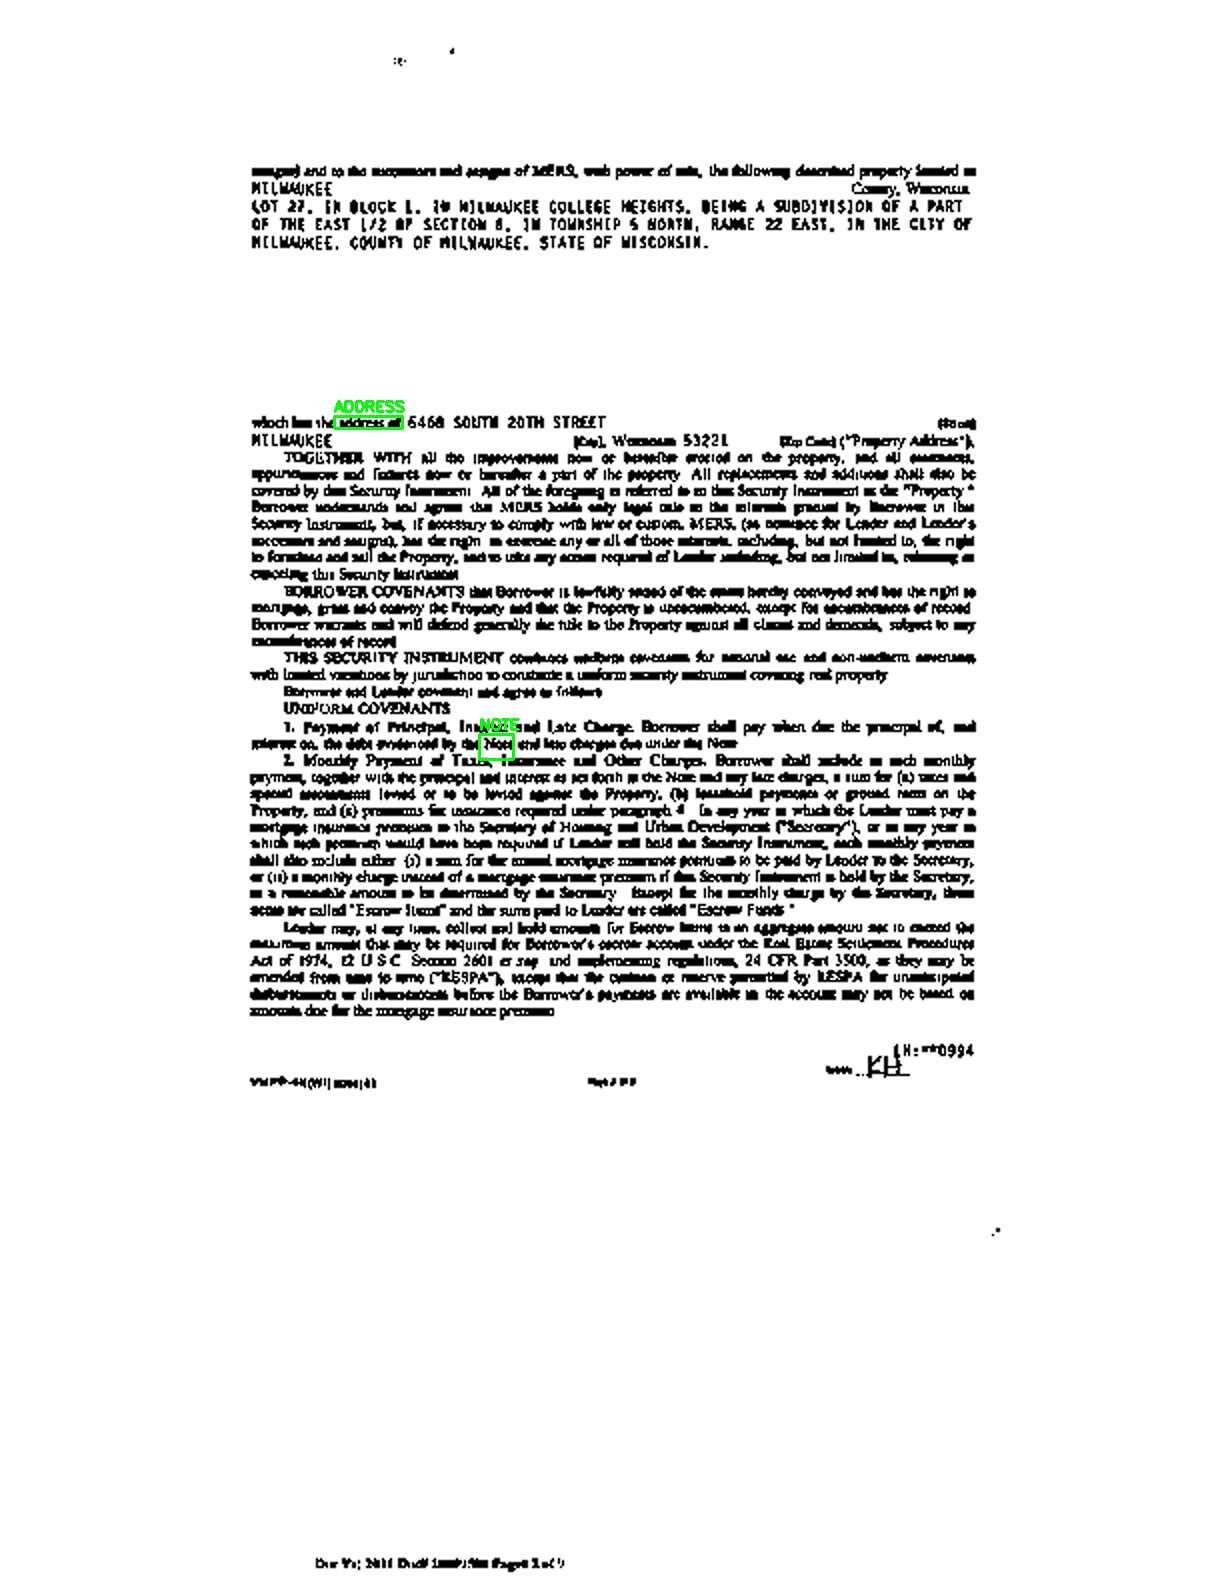

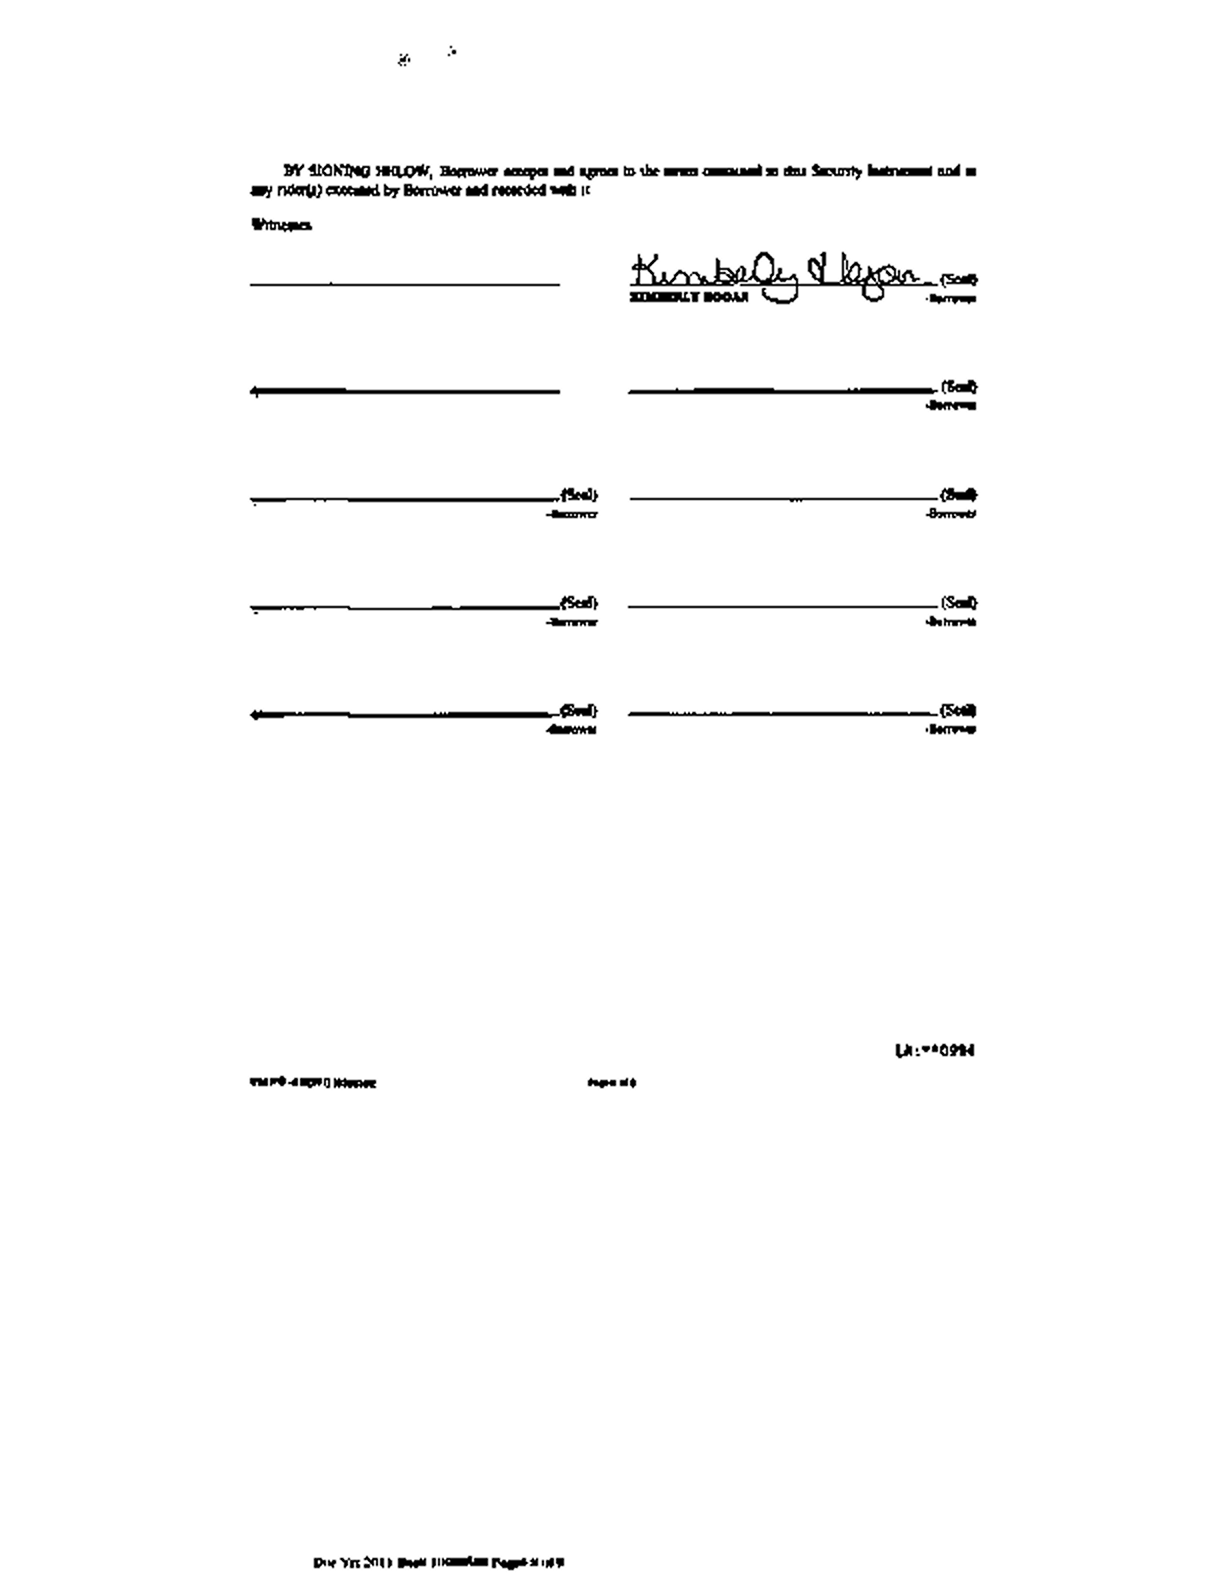

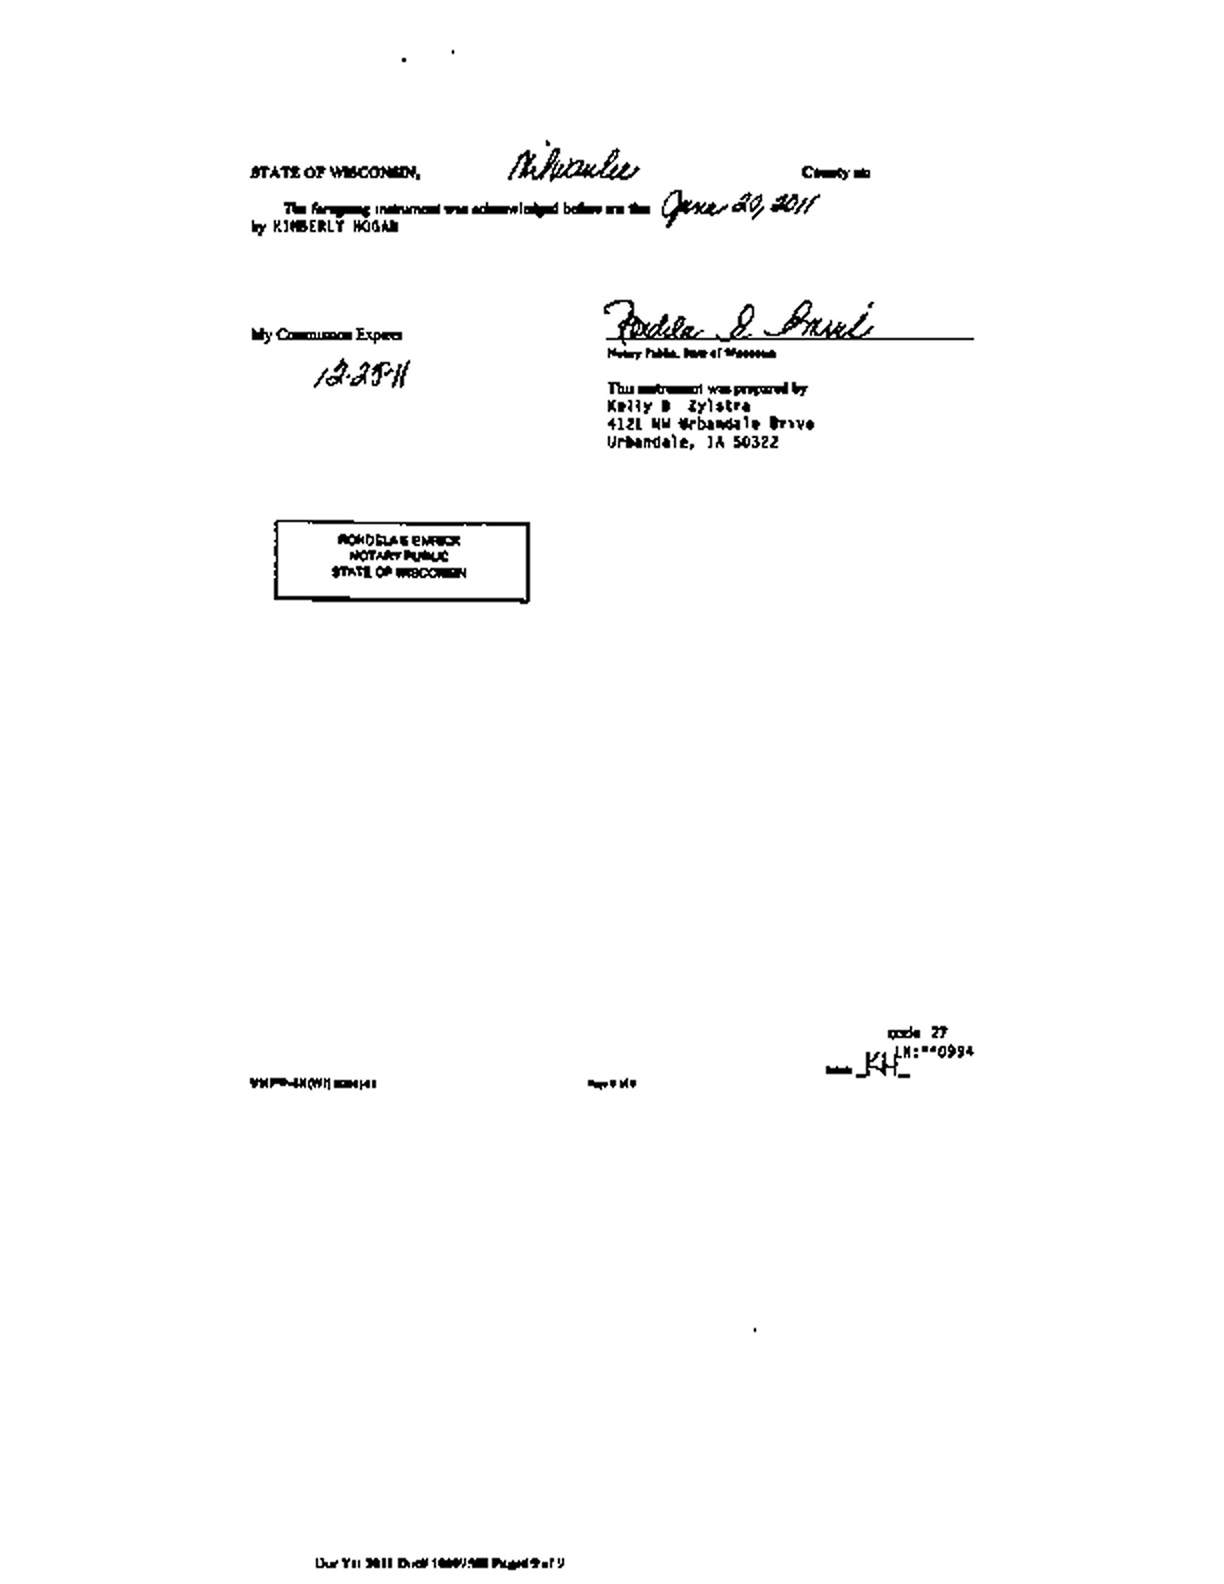

In [ ]:
for gray_img, ocr_data in zip(gray_imgs, ocr_datas):
  img_bgr = cv2.cvtColor(gray_img, cv2.COLOR_RGB2BGR)

  key_fields = ["MORTGAGE", "NOTE", "LENDER", "PROPERTY ADDRESS", "DATE", "SIGNATURE", "ADDRESS", "INTEREST RATE"]

  confidence_threshold = 40

  for i in range(len(ocr_data['text'])):
    word = ocr_data['text'][i].strip().upper()
    x, y, w, h = ocr_data['left'][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
    conf = int(ocr_data['conf'][i])

    if not word or conf < confidence_threshold:
      continue

    for key in key_fields:
      if key in word:
        cv2.rectangle(img_bgr, (x,y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_bgr, word, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(img_rgb))

Store in JSON format

In [ ]:
import json

extracted_data = {}
for ocr_data in ocr_datas:
  for i in range(len(ocr_data['text'])):
    word = ocr_data['text'][i].strip().upper()
    x, y, w, h = ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]

    if word in key_fields:
      extracted_data[word] = {
          'word': word,
          'BBOX': [x,y,w,h],
          'conf': ocr_data['conf'][i]
      }

json_output = json.dumps(extracted_data, indent=4)

print(json_output)

{
    "MORTGAGE": {
        "word": "MORTGAGE",
        "BBOX": [
            538,
            94,
            150,
            41
        ],
        "conf": 96
    },
    "ADDRESS": {
        "word": "ADDRESS",
        "BBOX": [
            334,
            416,
            68,
            12
        ],
        "conf": 78
    },
    "NOTE": {
        "word": "NOTE",
        "BBOX": [
            479,
            734,
            34,
            25
        ],
        "conf": 51
    }
}
